<a href="https://colab.research.google.com/github/douglasmasho/MedAlgo/blob/main/MedalgoclassifierKeras_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/medalgo2.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [3]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
from tensorflow.keras import models
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model

In [4]:
SAVE = False
SEED = 111
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
CLASS_TYPES = ['glioma', 'meningioma', 'notumor', 'pituitary']
N_TYPES = len(CLASS_TYPES)
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})
image_size = (150, 150)
batch_size = 32

In [6]:
import os

def get_data_labels(directory):
    paths, labels = [], []

    # Iterate over each folder in the directory
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)

        # Verify if the path is a directory
        if os.path.isdir(label_path):
            # Iterate over each file in the directory
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)

                # Append file path and its label
                paths.append(file_path)
                labels.append(label)

    return paths, labels

file1 = "/content/Training"
file2 = "/content/Testing"

# Retrieve data using the function
train_paths, train_labels = get_data_labels(file1)
test_paths, test_labels = get_data_labels(file2)

print('Training Set')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting Set')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')


Training Set
Number of Paths: 5712
Number of Labels: 5712

Testing Set
Number of Paths: 1311
Number of Labels: 1311


In [7]:
#Data augmentation source: guslovesmath https://www.kaggle.com/code/guslovesmath/cnn-brain-tumor-classification-99-accuracy/notebook

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    brightness_range=(0.85, 1.15),
    width_shift_range=0.002,
    height_shift_range=0.002,
    shear_range=12.5,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    directory=file1,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=SEED
)

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(
    directory=file2,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [9]:
class_indices_train = train_generator.class_indices
class_indices_train_list = [key for key in class_indices_train]

# Print class categories
print("Categorical types for the training data:")
print(class_indices_train)


Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [16]:
# Define the shape of the image
image_shape = (image_size[0], image_size[1], 3)

# Number of epochs for training
epochs = 60

# Calculate steps per epoch
steps_per_epoch = int(train_generator.samples / batch_size)

# Calculate validation steps
validation_steps = int(test_generator.samples / batch_size)


In [13]:
#Architecture source: guslovesmath https://www.kaggle.com/code/guslovesmath/cnn-brain-tumor-classification-99-accuracy/notebook

# Define the model architecture
model = models.Sequential()

# Layer 1
model.add(Conv2D(filters=32, kernel_size=(4, 4), activation="relu", input_shape=image_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Layer 2
model.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Layer 3
model.add(Conv2D(filters=128, kernel_size=(4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Layer 4
model.add(Conv2D(filters=128, kernel_size=(4, 4), activation="relu"))
model.add(Flatten())

# Fully connected layers
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(rate=0.5, seed=SEED))
model.add(Dense(units=N_TYPES, activation="softmax"))

model.summary()

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 147, 147, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 46, 46, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 1, 1, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 45.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


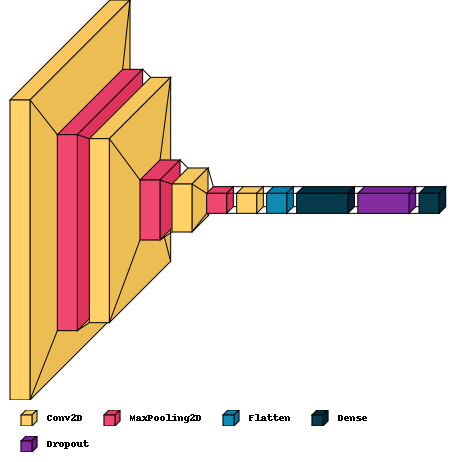

In [15]:
from visualkeras import layered_view

# Visualizing the model
layered_view(model, legend=True, max_xy=300)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define early stopping to halt training if validation loss does not improve
early_stopping = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)

# Define learning rate reduction to adjust the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Define model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=True)

# Fit the model with the training and validation data, and apply the callbacks
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4848 - loss: 1.0849
Epoch 1: val_loss improved from inf to 0.61605, saving model to best_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 65s 324ms/step - accuracy: 0.4855 - loss: 1.0837 - val_accuracy: 0.7477 - val_loss: 0.6160 - learning_rate: 0.0010
Epoch 2/60
  1/178 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8125 - loss: 0.4644

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.61605
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8125 - loss: 0.4644 - val_accuracy: 0.7419 - val_loss: 0.8962 - learning_rate: 0.0010
Epoch 3/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.7900 - loss: 0.5119
Epoch 3: val_loss did not improve from 0.61605
178/178 ━━━━━━━━━━━━━━━━━━━━ 65s 256ms/step - accuracy: 0.7901 - loss: 0.5118 - val_accuracy: 0.7383 - val_loss: 0.6625 - learning_rate: 0.0010
Epoch 4/60
  1/178 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7812 - loss: 0.5244
Epoch 4: val_loss improved from 0.61605 to 0.22379, saving model to best_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.5244 - val_accuracy: 0.9677 - val_loss: 0.2238 - learning_rate: 0.0010
Epoch 5/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8250 - loss: 0.4394
Epoch 5: val_loss did not improve from 0.22379
178/178 ━━━━━━━━━━━━━━━━━━━━ 84s 269ms/step - accuracy: 0.8251 - loss: 0.4393 - val_

In [ ]:
# Evaluate the model on the test set
eval_results = model.evaluate(
    x=test_generator,
    steps=int(test_generator.samples / batch_size)
)

# Unpack the evaluation results
loss, accuracy = eval_results

print(f"Test Loss: {loss:.5f}")
print(f"Test Accuracy: {accuracy:.5f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9574 - loss: 0.1352
Test Loss: 0.09402
Test Accuracy: 0.97344


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


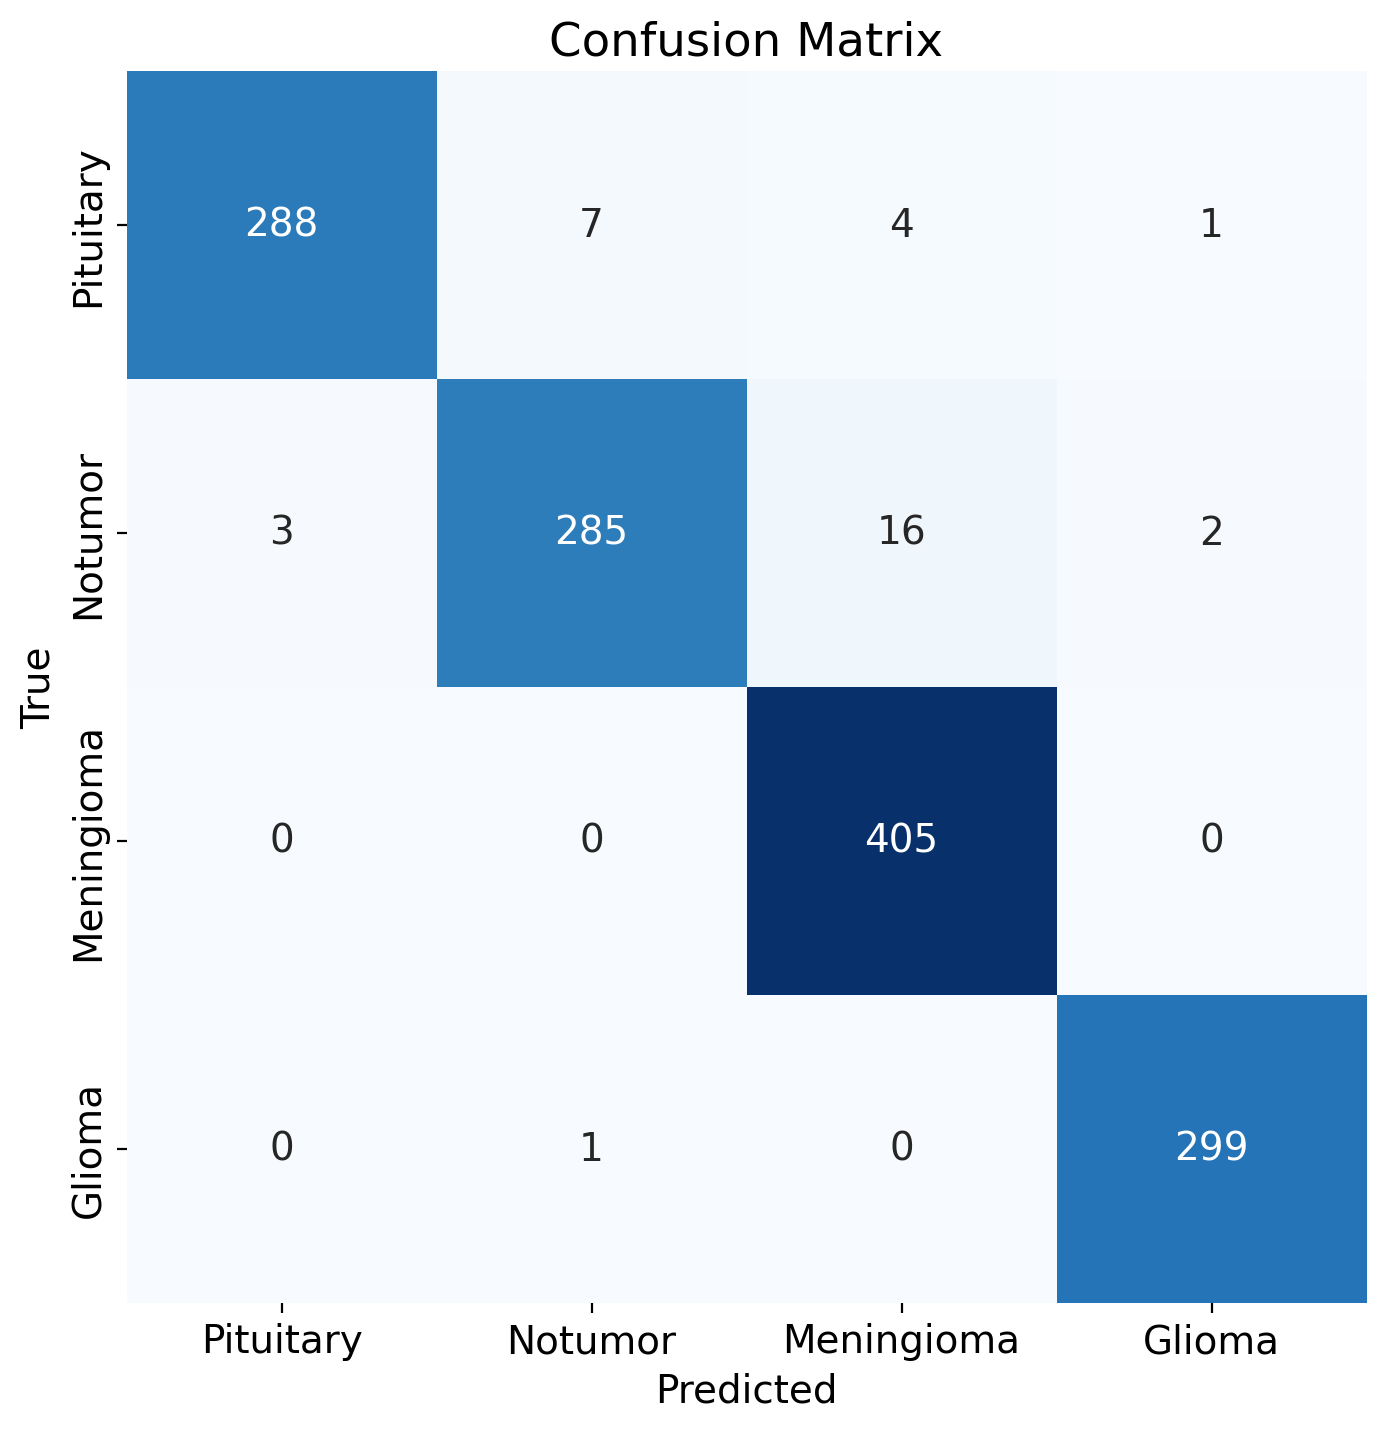

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Getting true labels and predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Create confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

class_indices_train_list = ['pituitary', 'notumor', 'meningioma', 'glioma']
# Load the model
model = tf.keras.models.load_model('/content/best_model.keras')

# Verify the model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 147, 147, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 1, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,487,918 (5.68 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,946 (3.78 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Class Probabilities:
glioma: 0.9999
meningioma: 0.0001
notumor: 0.0000
pituitary: 0.0000

Predicted Class: glioma (Index: 0)


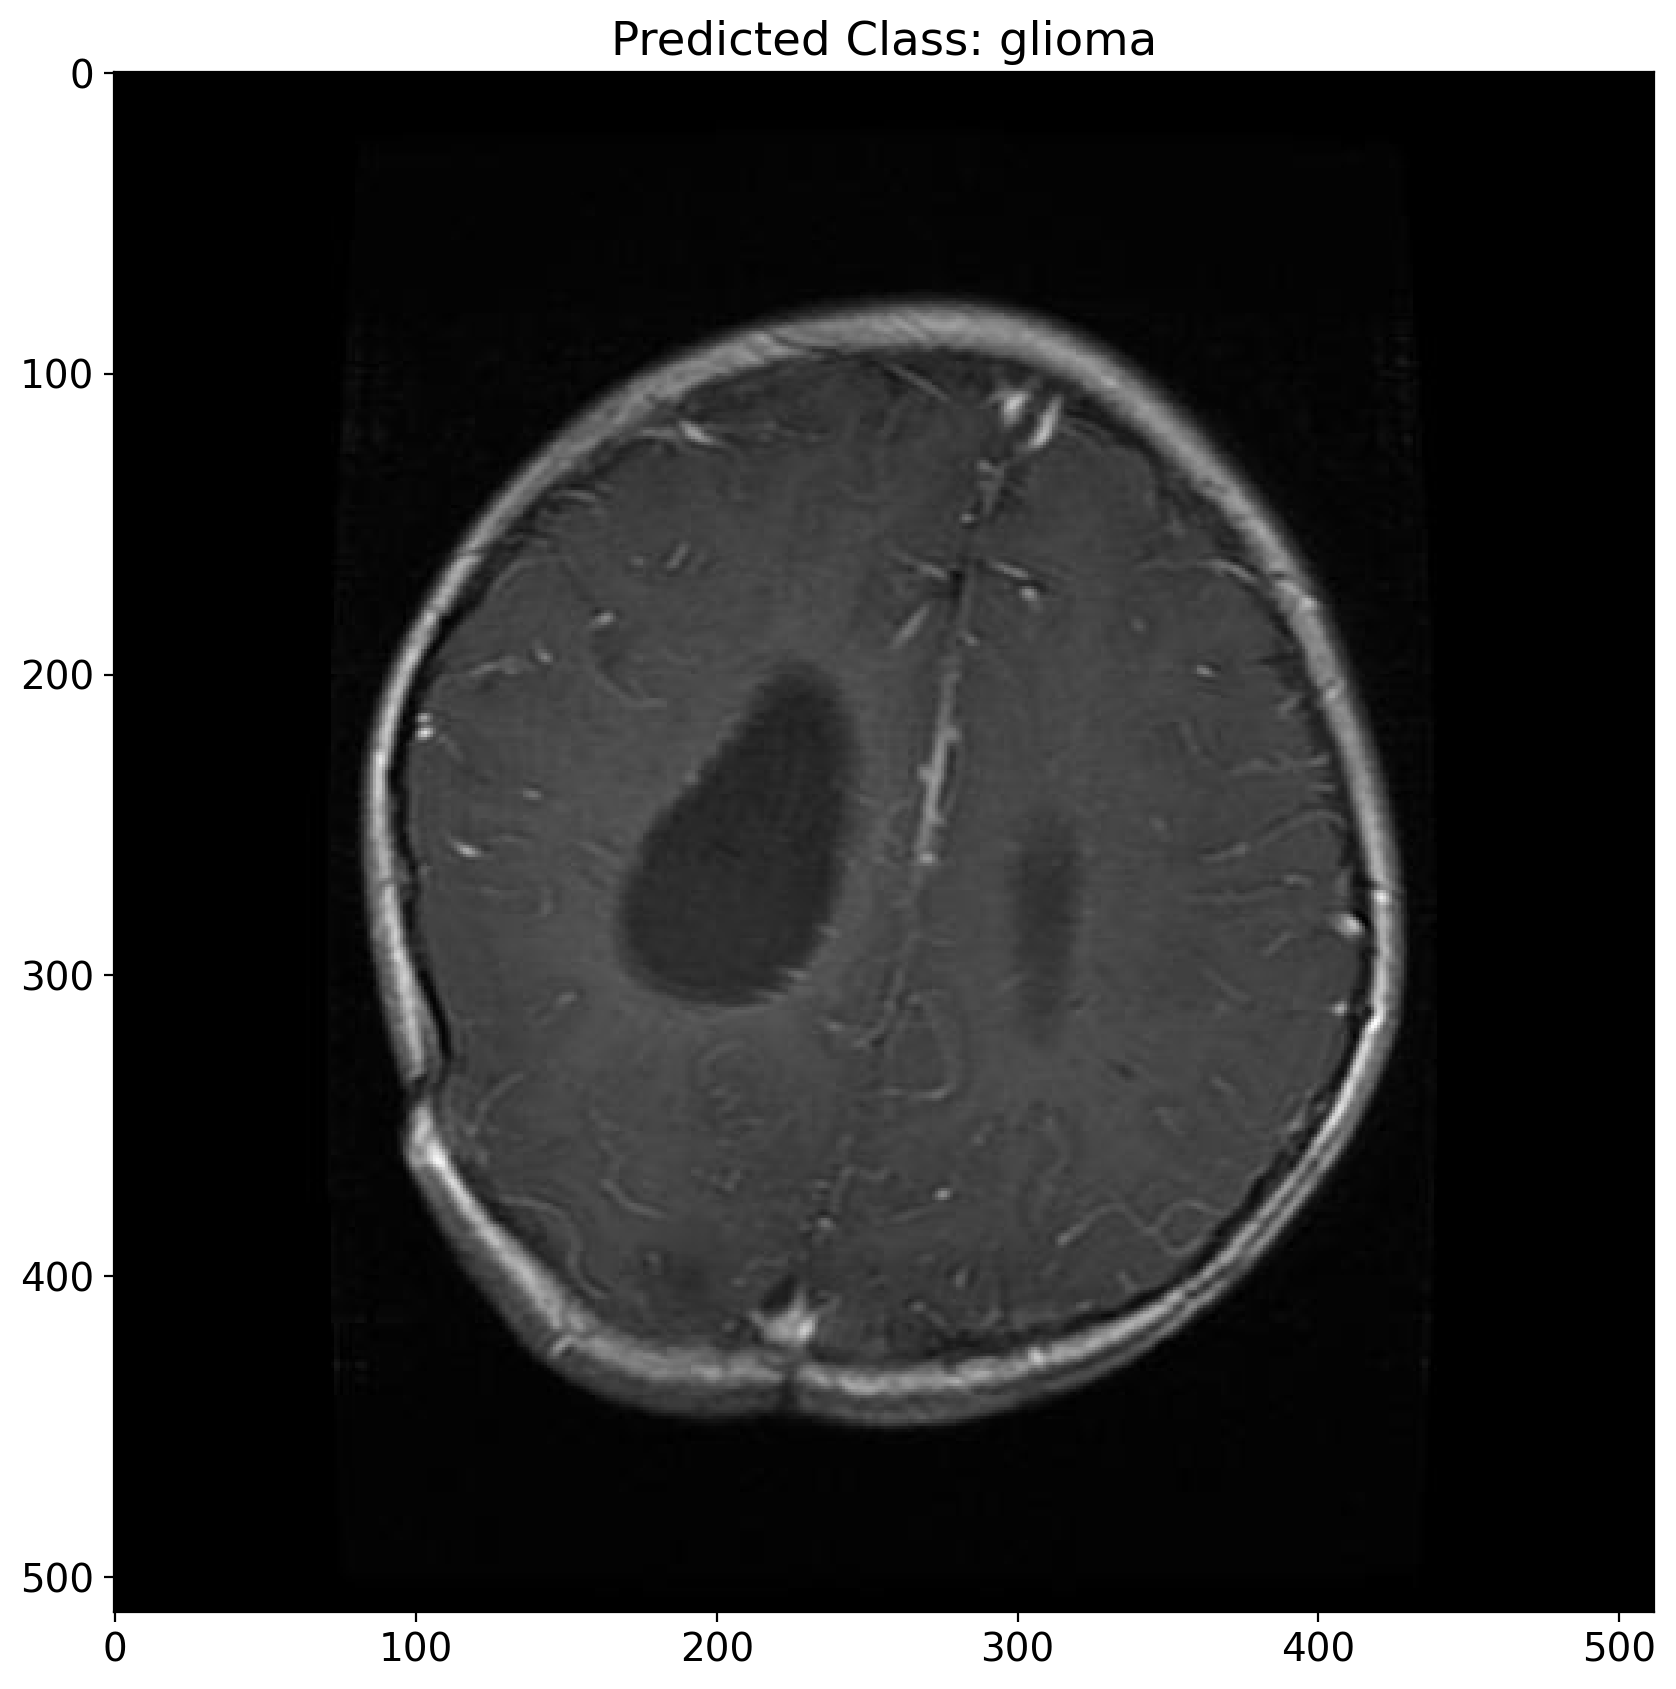

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model

# Global Variables
SEED = 111
CLASS_TYPES = ['glioma','meningioma', 'notumor','pituitary']
N_TYPES = len(CLASS_TYPES)
image_size = (150, 150)

# Load the trained model
model = load_model('/content/best_model.keras')

# Load and preprocess the image
def preprocess_image(image_path, target_size):
    img = keras_image.load_img(image_path, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Path to the image to be tested
image_path = "/content/Te-gl_0018.jpg"

# Preprocess the image
preprocessed_image = preprocess_image(image_path, target_size=image_size)

# Make predictions
predictions = model.predict(preprocessed_image)
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = CLASS_TYPES[predicted_class_index]

# Print the probabilities and predicted class
print("Class Probabilities:")
for i, label in enumerate(CLASS_TYPES):
    print(f"{label}: {predictions[0][i]:.4f}")

print(f"\nPredicted Class: {predicted_class_name} (Index: {predicted_class_index})")

# Display the image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.show()
